# Imports:

In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
from importlib import reload 
from art.attacks.evasion import AutoProjectedGradientDescent,ProjectedGradientDescent,AdversarialPatchPyTorch,BasicIterativeMethod,CarliniL2Method,CarliniLInfMethod
from art.estimators.classification import PyTorchClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,precision_score,recall_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from joblib import dump, load
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from torch.utils.data import TensorDataset, DataLoader,SubsetRandomSampler
from torchvision import transforms, datasets
from tqdm import tqdm  
import os
import cv2
from MPD_Thres import MPD_Threshold_Calculator
import AEFinder
import AE_Generator
import MPD
import MPD_Thres
from sklearn.model_selection import train_test_split

reload(AEFinder)
reload(AE_Generator)
reload(MPD)
reload(MPD_Thres)
from AE_Generator import AEGenerator
from MPD import MPD_Evaluator
from MPD_Thres import MPD_Threshold_Calculator


# Create the Model Architechture:

In [2]:
######################## MNIST Model #########################
class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3)  # input channels=1 (grayscale), output channels=32, kernel_size=3x3
        self.conv2 = nn.Conv2d(32, 32, 3) # input channels=32, output channels=32, kernel_size=3x3
        self.maxpool1 = nn.MaxPool2d(2)   # kernel_size=2x2, default stride=2
        self.conv3 = nn.Conv2d(32, 64, 3) # input channels=32, output channels=64, kernel_size=3x3
        self.conv4 = nn.Conv2d(64, 64, 3) # input channels=64, output channels=64, kernel_size=3x3
        self.maxpool2 = nn.MaxPool2d(2)   # kernel_size=2x2, default stride=2
        self.fc1 = nn.Linear(64 * 4 * 4, 512) # 64 channels * 4x4 feature map size, output features=512
        self.fc2 = nn.Linear(512, 10)     # 512 input features, output classes=10

    def forward(self, x):
        x = F.relu(self.conv1(x))         # Conv1 -> ReLU
        x = F.relu(self.conv2(x))         # Conv2 -> ReLU
        x = self.maxpool1(x)              # MaxPool1
        x = F.relu(self.conv3(x))         # Conv3 -> ReLU
        x = F.relu(self.conv4(x))         # Conv4 -> ReLU
        x = self.maxpool2(x)              # MaxPool2
        x = x.view(-1, 64 * 4 * 4)        # Flatten before FC layer
        x = F.relu(self.fc1(x))           # FC1 -> ReLU
        x = self.fc2(x)                   # FC2 (no activation applied here, will be handled in the loss function)
        return x

# Dataloaders:

In [3]:
transform = transforms.Compose([transforms.Grayscale(num_output_channels=1),transforms.Resize((28, 28)),transforms.ToTensor(),])

In [4]:
train_dataset = datasets.ImageFolder(root='D:/Code/Lab105_Personal/Atharva_MPD/Datasets/MNIST/train_image', transform=transform)
print(f"Length of training dataset: {len(train_dataset)}")
train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True, num_workers=4)

Length of training dataset: 55000


In [5]:
test_dataset = datasets.ImageFolder(root='D:/Code/Lab105_Personal/Atharva_MPD/Datasets/MNIST/test_image', transform=transform)
print(f"Length of test dataset: {len(test_dataset)}")
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False, num_workers=8)

Length of test dataset: 10000


# Load the Test Set:

In [6]:
# Load variables from file
x_test = np.load('mnist_x_test.npy')
y_test = np.load('mnist_y_test.npy')

# Load base MNIST Model:

In [7]:
# Check if GPU is available and move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

base_model =MNISTClassifier()
base_model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(base_model.parameters(), lr=0.001)

cuda


In [8]:
# Define the path to the saved model file
model_path = "MNIST_Clean/MNIST_Clean_Model.pth"

# Load only the model's parameters
state_dict = torch.load(model_path, map_location=torch.device('cuda'))

# Load the parameters into the model
base_model.load_state_dict(state_dict)

<All keys matched successfully>

# Create ART Classifier:

In [9]:
# Step 3: Create the ART classifier

classifier = PyTorchClassifier(
    model=base_model,
    loss=criterion,
    optimizer=optimizer,
    input_shape=(1, 28, 28),
    nb_classes=10,
    device_type='cuda',
    clip_values=(0.0,1.0)
    
)

In [10]:
#Evaluate the ART classifier on benign test examples

predictions = classifier.predict(x_test)
predictions=np.argmax(predictions, axis=1)
accuracy = np.sum(predictions == y_test) / len(y_test)
print(f"Accuracy on the test set: {accuracy*100}%")

Accuracy on the test set: 99.27%


# Find the best Hyper-parameters for AE Generation:

In [11]:
# bim=AEFinder.AE_Finder(classifier,'bim',x_test,y_test)

In [12]:
# bim.finder()

Best eps: 0.22, Best eps_step: 0.03, Best max_iter: 40, Maximum successful attacks: 100

In [13]:
# pgd=AEFinder.AE_Finder(classifier,'pgdlinf',x_test,y_test)

In [14]:
# pgd.finder()

Best eps: 0.21000000000000002, Best eps_step: 0.01, Best max_iter: 60, Maximum successful attacks: 100

In [15]:
# apgd=AEFinder.AE_Finder(classifier,'apgdlinf',x_test,y_test)

In [16]:
# apgd.finder()

Best eps: 0.21000000000000002, Best eps_step: 0.060000000000000005, Best max_iter: 50, Maximum successful attacks: 100

# Generate AEs:

# BIM:

In [17]:
# bim_attack=AEGenerator(classifier, 'bim', x_test, y_test,eps=0.22,eps_step=0.03,max_iter=40)

In [18]:
# dump(bim_attack,'AttackSamples/bim_attack.joblib')

In [19]:
#Loading the samples 
bim_attack=load('AttackSamples/bim_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(bim_attack.attack_name.upper(), bim_attack.acc_adv * 100))
print()
print(f"The number of {bim_attack.attack_name.upper()} samples that successfully evaded the model are - {len(bim_attack.false_indices)}")

Accuracy on BIM adversarial test examples: 1.38%

The number of BIM samples that successfully evaded the model are - 9862


# PGD:

In [20]:
# pgd_attack=AEGenerator(classifier, 'pgdlinf', x_test, y_test,eps=0.21,eps_step=0.01,max_iter=60)

In [21]:
# dump(pgd_attack,'AttackSamples/pgd_attack.joblib')

In [22]:
#Loading the samples 
pgd_attack=load('AttackSamples/pgd_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(pgd_attack.attack_name.upper(), pgd_attack.acc_adv * 100))
print()
print(f"The number of {bim_attack.attack_name.upper()} samples that successfully evaded the model are - {len(pgd_attack.false_indices)}")

Accuracy on PGDLINF adversarial test examples: 2.92%

The number of BIM samples that successfully evaded the model are - 9708


# APGD:

In [23]:
# apgd_attack=AEGenerator(classifier, 'apgdlinf', x_test, y_test,eps=0.21,eps_step=0.06,max_iter=50)

In [24]:
# dump(apgd_attack,'AttackSamples/apgd_attack.joblib')

In [25]:
#Loading the samples 
apgd_attack=load('AttackSamples/apgd_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(apgd_attack.attack_name.upper(), apgd_attack.acc_adv * 100))
print()
print(f"The number of {apgd_attack.attack_name.upper()} samples that successfully evaded the model are - {len(apgd_attack.false_indices)}")

Accuracy on APGDLINF adversarial test examples: 1.01%

The number of APGDLINF samples that successfully evaded the model are - 9899


# CW:

In [26]:
#Loading the samples 
cw_attack=load('AttackSamples/cw_attack.joblib')
print("Accuracy on {} adversarial test examples: {}%".format(cw_attack.attack_name.upper(), cw_attack.acc_adv * 100))
print()
print(f"The number of {cw_attack.attack_name.upper()} samples that successfully evaded the model are - {len(cw_attack.false_indices)}")

Accuracy on CWLINF adversarial test examples: 1.8599999999999999%

The number of CWLINF samples that successfully evaded the model are - 9814


# Adversarial Patch:

In [27]:
# ap= AdversarialPatchPyTorch(classifier,
#                                 learning_rate=0.01,
#                             patch_shape = (1, 28, 28),
#                             targeted=False,
#                             verbose = True,
#                             batch_size= 1000,
# )

In [28]:
patch=load('AttackSamples/patch.joblib')
patch=patch[0]

In [29]:
x_test_ap=load('AttackSamples/AP_AES.joblib')

### Patch Image:

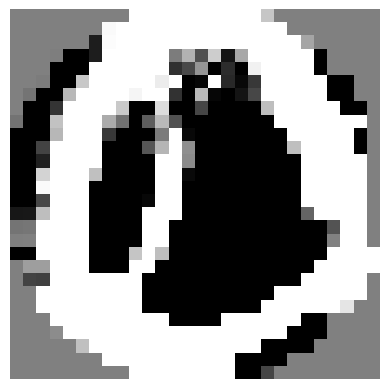

In [30]:
plt.imshow(patch.reshape(28, 28), cmap='gray')
plt.axis('off')
plt.show()

In [31]:

# Evaluate the ART classifier on the adversarial test examples
ap_adv_preds = classifier.predict(x_test_ap)

# Getting the individual predictions and their indices
ap_ind_pred = np.argmax(ap_adv_preds, axis=1) == y_test
ap_false_indices = np.where(~ap_ind_pred)[0].tolist()

# Calculating the accuracy
ap_acc_adv = np.sum(np.argmax(ap_adv_preds, axis=1)==y_test) / len(y_test)
print("Accuracy on {} adversarial test examples: {}%".format('Adversarial Patch', ap_acc_adv * 100))
print()
print(f"The number of Adversarial Patch samples that successfully evaded the model are - {len(ap_false_indices)}")

Accuracy on Adversarial Patch adversarial test examples: 55.43%

The number of Adversarial Patch samples that successfully evaded the model are - 4457


# MPD

## Loading the Ensemble Models:

In [32]:
# Define the directory where the models are saved
save_dir = "MNIST_Ensemble/"

# List to store loaded model
ensemble_models = []

# Loop through each saved model file
for i in range(100):
    # Define the path to the saved model file
    model_path = os.path.join(save_dir, f"model_{i+1}.pth")
    # Instantiate the model architecture
    model = MNISTClassifier()
    # Load the saved model state dictionary
    model.load_state_dict(torch.load(model_path))
    # Append the loaded model to the list
    ensemble_models.append(model)

In [33]:
mpd_detector=MPD_Evaluator(ensemble_models, 10, 100)

## Getting the AEs 

In [34]:
x_test_bim=bim_attack.x_test_adv
x_test_pgdlinf=pgd_attack.x_test_adv
x_test_apgdlinf=apgd_attack.x_test_adv
x_test_cwlinf=cw_attack.x_test_adv

In [35]:
print(f"Shape of Clean Samples - {x_test.shape}")
print(f"Shape of BIM Samples - {x_test_bim.shape}")
print(f"Shape of PGD Samples - {x_test_pgdlinf.shape}")
print(f"Shape of AutoPGD Samples - {x_test_apgdlinf.shape}")
print(f"Shape of CW Samples - {x_test_cwlinf.shape}")
print(f"Shape of AE Samples - {x_test_ap.shape}")

Shape of Clean Samples - (10000, 1, 28, 28)
Shape of BIM Samples - (10000, 1, 28, 28)
Shape of PGD Samples - (10000, 1, 28, 28)
Shape of AutoPGD Samples - (10000, 1, 28, 28)
Shape of CW Samples - (10000, 1, 28, 28)
Shape of AE Samples - (10000, 1, 28, 28)


In [36]:
mpd_scores_normal=mpd_detector.evaluate(x_test)

In [37]:
mpd_scores_bim=mpd_detector.evaluate(x_test_bim)

In [38]:
mpd_scores_pgd=mpd_detector.evaluate(x_test_pgdlinf)

In [39]:
mpd_scores_apgd=mpd_detector.evaluate(x_test_apgdlinf)

In [40]:
mpd_scores_cw=mpd_detector.evaluate(x_test_cwlinf)

In [41]:
mpd_scores_ap=mpd_detector.evaluate(x_test_ap)


In [42]:
atks = {
    'clean':mpd_scores_normal,
    'bim': mpd_scores_bim,
    'pgd': mpd_scores_pgd,
    'autopgd': mpd_scores_apgd,
    'cw': mpd_scores_cw,
    'ap':mpd_scores_ap
}

In [43]:
max_mpd_scores = {}

def mpd_maxscores(atk_name, mpd_scores):
    max_value = round(mpd_scores.max(), 2)
    max_mpd_scores[atk_name] = max_value
    print(f"The max mpd score for {atk_name.upper()} = {max_value}")

In [44]:
for names in atks.keys():
    mpd_maxscores(names,atks[names])

The max mpd score for CLEAN = 0.74
The max mpd score for BIM = 0.81
The max mpd score for PGD = 0.8
The max mpd score for AUTOPGD = 0.81
The max mpd score for CW = 0.77
The max mpd score for AP = 0.83


In [96]:
def mpd_score_graph(atk_name,mpd_scores):
    if atk_name=='clean':
        sns.displot(mpd_scores, kde = True, aspect = 2)
        plt.title("MPD scores before attack")
        plt.ylim(0,1400)
    else:
        sns.displot(mpd_scores, kde = True, aspect = 2)
        plt.title(f"MPD scores after {atk_name.upper()} attack")
        plt.ylim(0,1400)

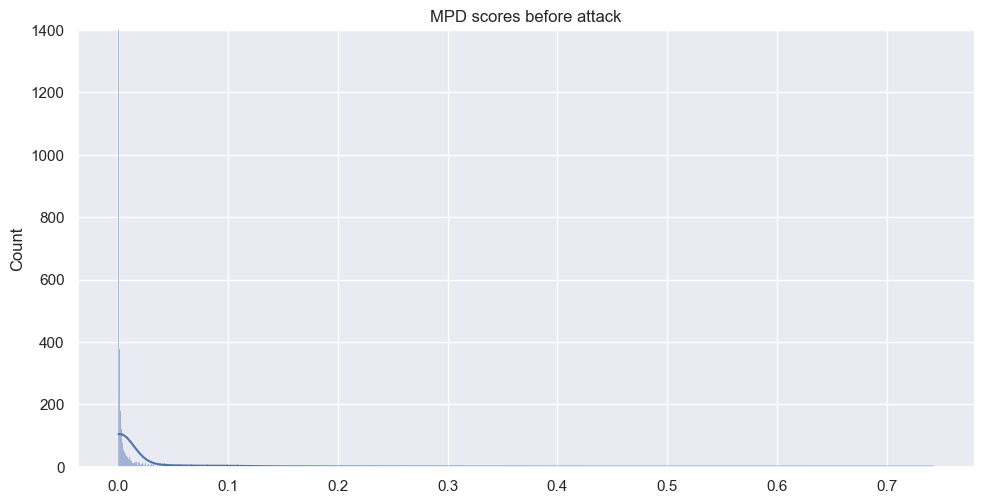

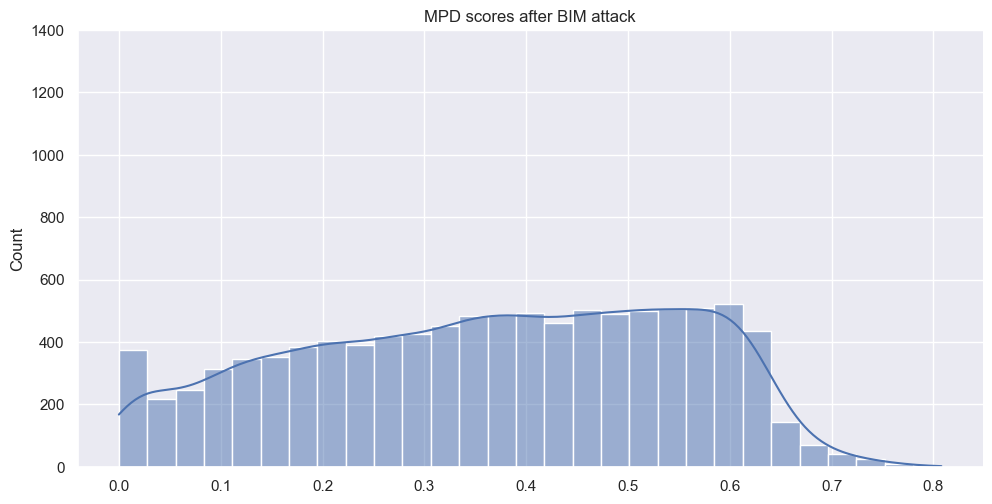

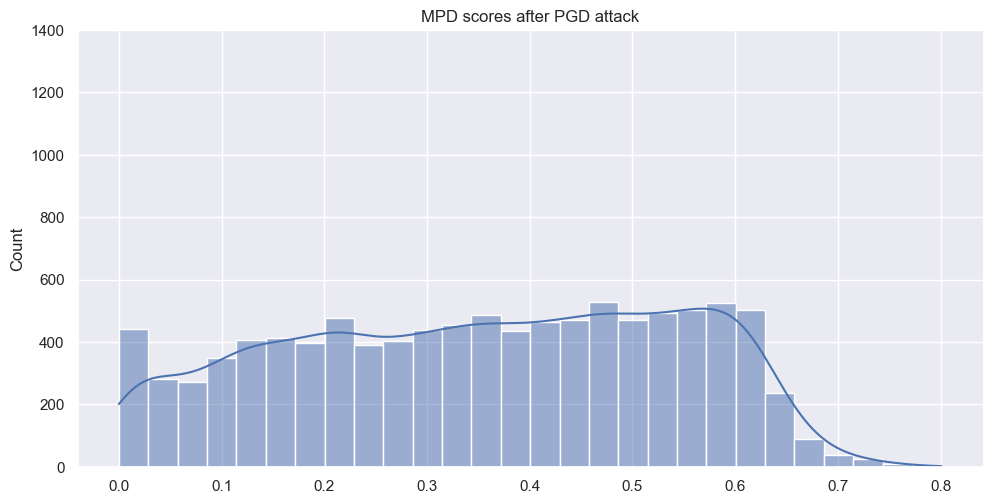

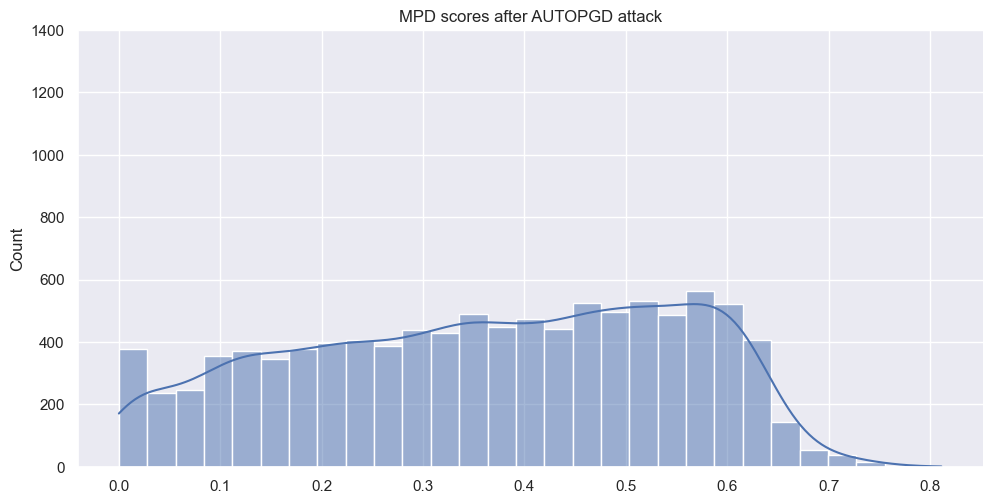

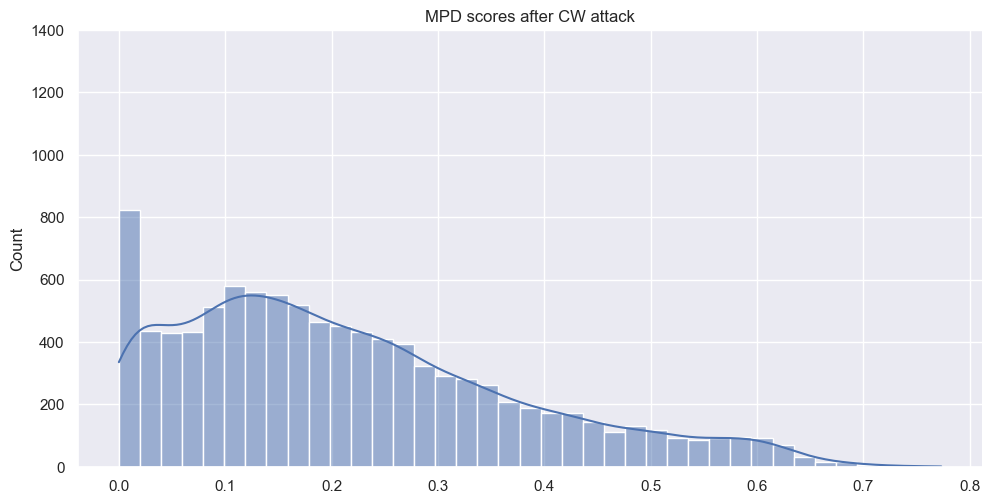

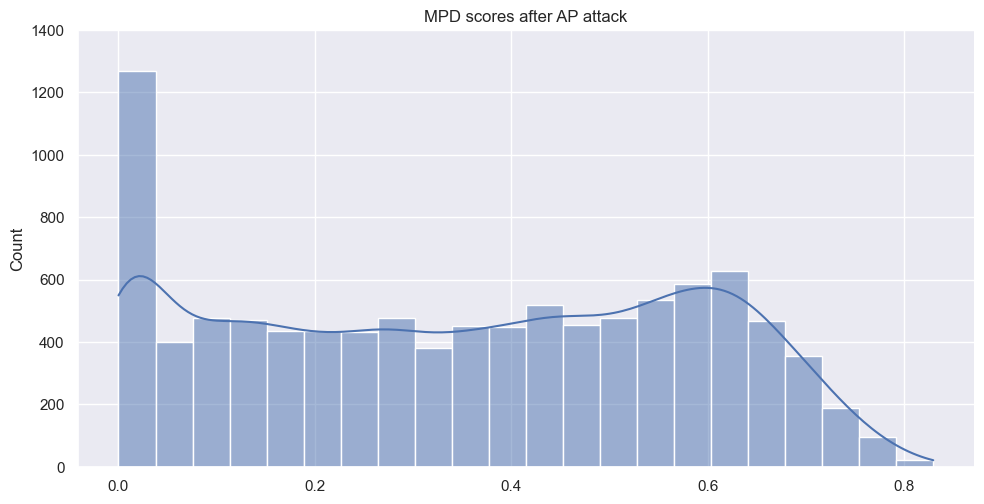

In [97]:
for names in atks.keys():
    mpd_score_graph(names,atks[names])

In [36]:
# Find common elements across all lists
common_indices = list(set(bim_attack.false_indices) & set(pgd_attack.false_indices) & set(apgd_attack.false_indices) & set(cw_attack.false_indices) )
#print("Common Indices:", common_indices)
print("Common Samples found :", len(common_indices))

Common Samples found : 9600


In [48]:
common_samples_cln=x_test[common_indices]

In [49]:
common_samples_bim=x_test_bim[common_indices]

In [50]:
common_samples_pgd=x_test_pgdlinf[common_indices]

In [51]:
common_samples_apgd=x_test_apgdlinf[common_indices]

In [52]:
common_samples_cw=x_test_cwlinf[common_indices]

In [40]:
working_samples_ap_clean=x_test[ap_false_indices]
working_samples_ap=x_test_ap[ap_false_indices]
ap_y_test=y_test[ap_false_indices]

In [54]:
#Function for class distribution
def class_dist(labels):
    # get unique class labels and their counts
    unique_classes, class_counts= np.unique(labels, return_counts=True)

    # Print the class distribution
    for label, count in zip(unique_classes, class_counts):
        print(f"Class {label}: {count} samples")

In [55]:
y_common_samples=y_test[common_indices]
class_dist(y_common_samples)

Class 0: 904 samples
Class 1: 1122 samples
Class 2: 999 samples
Class 3: 869 samples
Class 4: 974 samples
Class 5: 872 samples
Class 6: 933 samples
Class 7: 976 samples
Class 8: 954 samples
Class 9: 997 samples


In [56]:
x_test_stratified_clean, _, y_test_stratified_clean, _ = train_test_split(x_test, y_test, test_size=0.25, stratify=y_test, random_state=333)

# Now, x_test_stratified and y_test_stratified contain 75% of the stratified test data
print("Shape of x_test_stratified:", x_test_stratified_clean.shape)
print("Shape of y_test_stratified:", y_test_stratified_clean.shape)

Shape of x_test_stratified: (7500, 1, 28, 28)
Shape of y_test_stratified: (7500,)


In [57]:
class_dist(y_test_stratified_clean)

Class 0: 735 samples
Class 1: 851 samples
Class 2: 774 samples
Class 3: 757 samples
Class 4: 737 samples
Class 5: 669 samples
Class 6: 719 samples
Class 7: 771 samples
Class 8: 730 samples
Class 9: 757 samples




Shape of x_test_stratified_bim: (2500, 1, 28, 28)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for BIM :
Class 0: 235 samples
Class 1: 292 samples
Class 2: 260 samples
Class 3: 226 samples
Class 4: 254 samples
Class 5: 227 samples
Class 6: 243 samples
Class 7: 254 samples
Class 8: 249 samples
Class 9: 260 samples


Accuracy on the Clean Samples: 99.88%
Accuracy on the Adversarial Samples: 0.0%
Shape of x_adv_testbed for BIM: (10000, 1, 28, 28)
Shape of y_adv_testbed: (10000,)


Class Distribution for bim :
Class 0: 7500 samples
Class 1: 2500 samples




    Threshold_value      TP     FP     FN      TN  recall  f1_score  accuracy
11             0.12  7028.0  472.0  270.0  2230.0   0.892  0.857363    0.9258
Shape of False Positive (FP) samples: (472, 1, 28, 28)
Shape of False Negative (FN) samples: (270, 1, 28, 28)
Shape of False Positive (FP) labels: (472,)
Shape of False Negative (FN) labels: (270,)






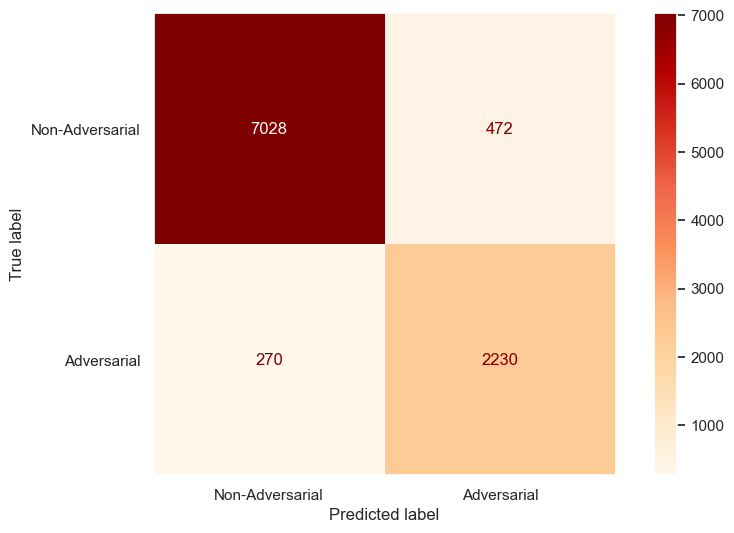

In [58]:
bim_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'bim',common_samples_cln,common_samples_bim,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)



Shape of x_test_stratified_bim: (2500, 1, 28, 28)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for PGD :
Class 0: 235 samples
Class 1: 292 samples
Class 2: 260 samples
Class 3: 226 samples
Class 4: 254 samples
Class 5: 227 samples
Class 6: 243 samples
Class 7: 254 samples
Class 8: 249 samples
Class 9: 260 samples


Accuracy on the Clean Samples: 99.88%
Accuracy on the Adversarial Samples: 0.0%
Shape of x_adv_testbed for PGD: (10000, 1, 28, 28)
Shape of y_adv_testbed: (10000,)


Class Distribution for pgd :
Class 0: 7500 samples
Class 1: 2500 samples




    Threshold_value      TP     FP     FN      TN  recall  f1_score  accuracy
10             0.11  6986.0  514.0  262.0  2238.0  0.8952  0.852247    0.9224
Shape of False Positive (FP) samples: (514, 1, 28, 28)
Shape of False Negative (FN) samples: (262, 1, 28, 28)
Shape of False Positive (FP) labels: (514,)
Shape of False Negative (FN) labels: (262,)






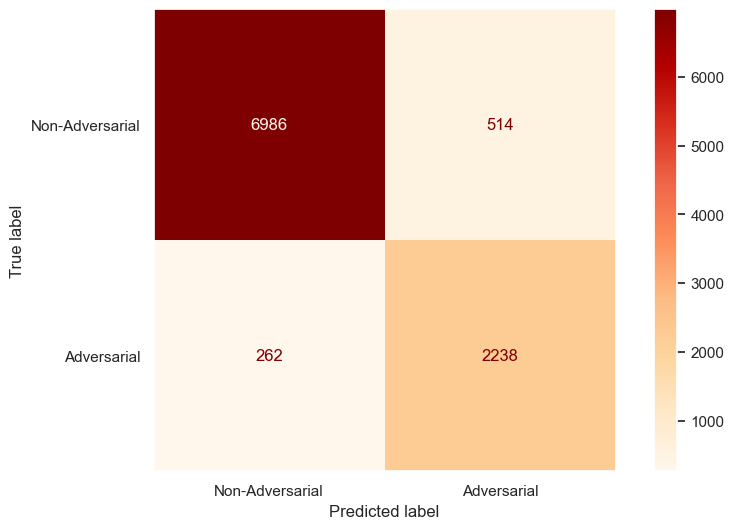

In [59]:
pgd_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'pgd',common_samples_cln,common_samples_pgd,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)



Shape of x_test_stratified_bim: (2500, 1, 28, 28)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for AUTOPGD :
Class 0: 235 samples
Class 1: 292 samples
Class 2: 260 samples
Class 3: 226 samples
Class 4: 254 samples
Class 5: 227 samples
Class 6: 243 samples
Class 7: 254 samples
Class 8: 249 samples
Class 9: 260 samples


Accuracy on the Clean Samples: 99.88%
Accuracy on the Adversarial Samples: 0.0%
Shape of x_adv_testbed for AUTOPGD: (10000, 1, 28, 28)
Shape of y_adv_testbed: (10000,)


Class Distribution for autopgd :
Class 0: 7500 samples
Class 1: 2500 samples




    Threshold_value      TP     FP     FN      TN  recall  f1_score  accuracy
11             0.12  7028.0  472.0  274.0  2226.0  0.8904  0.856483    0.9254
Shape of False Positive (FP) samples: (472, 1, 28, 28)
Shape of False Negative (FN) samples: (274, 1, 28, 28)
Shape of False Positive (FP) labels: (472,)
Shape of False Negative (FN) labels: (274,)






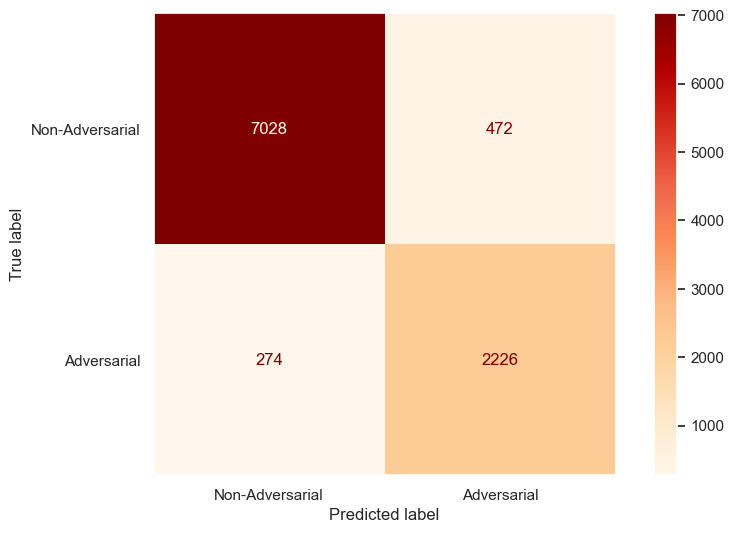

In [60]:
apgd_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'autopgd',common_samples_cln,common_samples_apgd,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)



Shape of x_test_stratified_bim: (2500, 1, 28, 28)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for CW :
Class 0: 235 samples
Class 1: 292 samples
Class 2: 260 samples
Class 3: 226 samples
Class 4: 254 samples
Class 5: 227 samples
Class 6: 243 samples
Class 7: 254 samples
Class 8: 249 samples
Class 9: 260 samples


Accuracy on the Clean Samples: 99.88%
Accuracy on the Adversarial Samples: 0.04%
Shape of x_adv_testbed for CW: (10000, 1, 28, 28)
Shape of y_adv_testbed: (10000,)


Class Distribution for cw :
Class 0: 7500 samples
Class 1: 2500 samples




   Threshold_value      TP     FP     FN      TN  recall  f1_score  accuracy
4             0.05  6591.0  909.0  335.0  2165.0   0.866  0.776821    0.8756
Shape of False Positive (FP) samples: (909, 1, 28, 28)
Shape of False Negative (FN) samples: (335, 1, 28, 28)
Shape of False Positive (FP) labels: (909,)
Shape of False Negative (FN) labels: (335,)






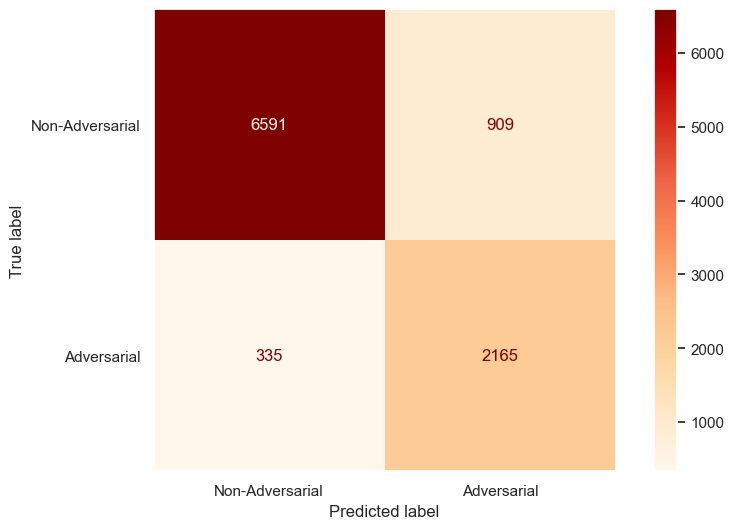

In [61]:
cw_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'cw',common_samples_cln,common_samples_cw,y_common_samples,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)




Shape of x_test_stratified_bim: (2500, 1, 28, 28)
Shape of y_test_stratified_bim: (2500,)


Class Distribution for AP :
Class 0: 171 samples
Class 1: 565 samples
Class 2: 194 samples
Class 3: 183 samples
Class 4: 197 samples
Class 5: 223 samples
Class 6: 127 samples
Class 7: 418 samples
Class 8: 107 samples
Class 9: 315 samples


Accuracy on the Clean Samples: 98.92%
Accuracy on the Adversarial Samples: 0.0%
Shape of x_adv_testbed for AP: (10000, 1, 28, 28)
Shape of y_adv_testbed: (10000,)


Class Distribution for ap :
Class 0: 7500 samples
Class 1: 2500 samples




    Threshold_value      TP     FP     FN      TN  recall  f1_score  accuracy
14             0.15  7130.0  370.0  231.0  2269.0  0.9076  0.883051    0.9399
Shape of False Positive (FP) samples: (370, 1, 28, 28)
Shape of False Negative (FN) samples: (231, 1, 28, 28)
Shape of False Positive (FP) labels: (370,)
Shape of False Negative (FN) labels: (231,)






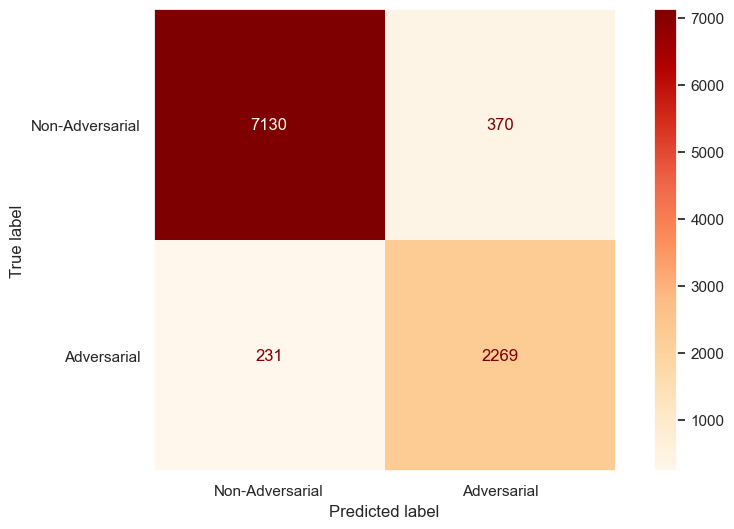

In [62]:
ap_mpd=MPD_Threshold_Calculator(classifier,mpd_detector,'ap',working_samples_ap_clean,working_samples_ap,ap_y_test,x_test_stratified_clean,y_test_stratified_clean,max_mpd_scores)


# Evaluating the False Positives:

## BIM FP Samples:

In [63]:
#Evaluate the ART classifier on benign test examples
bim_predictions = classifier.predict(bim_mpd.FP_samples)
bim_predictions=np.argmax(bim_predictions, axis=1)
bim_accuracy = np.sum(bim_predictions == bim_mpd.FP_labels) / len(bim_mpd.FP_labels)
print(f"Accuracy on the test set: {accuracy*100}%")

Accuracy on the test set: 99.27%


## PGD Samples:

In [64]:
#Evaluate the ART classifier on benign test examples
pgd_predictions = classifier.predict(pgd_mpd.FP_samples)
pgd_predictions=np.argmax(pgd_predictions, axis=1)
pgd_accuracy = np.sum(pgd_predictions == pgd_mpd.FP_labels) / len(pgd_mpd.FP_labels)
print(f"Accuracy on the test set: {pgd_accuracy*100}%")

Accuracy on the test set: 4.863813229571985%


## APGD Samples:

In [65]:
#Evaluate the ART classifier on benign test examples
apgd_predictions = classifier.predict(apgd_mpd.FP_samples)
apgd_predictions=np.argmax(apgd_predictions, axis=1)
apgd_accuracy = np.sum(apgd_predictions == apgd_mpd.FP_labels) / len(apgd_mpd.FP_labels)
print(f"Accuracy on the test set: {apgd_accuracy*100}%")

Accuracy on the test set: 5.296610169491525%


# CW Samples:

In [66]:
#Evaluate the ART classifier on benign test examples
cw_predictions = classifier.predict(cw_mpd.FP_samples)
cw_predictions=np.argmax(cw_predictions, axis=1)
cw_accuracy = np.sum(cw_predictions == cw_mpd.FP_labels) / len(cw_mpd.FP_labels)
print(f"Accuracy on the test set: {cw_accuracy*100}%")

Accuracy on the test set: 5.2805280528052805%


# AP Samples:

In [67]:
#Evaluate the ART classifier on benign test examples
ap_predictions = classifier.predict(ap_mpd.FP_samples)
ap_predictions=np.argmax(ap_predictions, axis=1)
ap_accuracy = np.sum(ap_predictions == ap_mpd.FP_labels) / len(ap_mpd.FP_labels)
print(f"Accuracy on the test set: {ap_accuracy*100}%")

Accuracy on the test set: 5.135135135135135%


In [68]:
def plot_random_images(images, num_images=100, grid_size=(15, 15), cmap='gray'):
    """
    Plot random images from the given array.
    
    Parameters:
        images (numpy.ndarray): Array containing the images.
        num_images (int): Number of random images to plot (default is 100).
        grid_size (tuple): Size of the grid for plotting (default is (10, 10)).
        cmap (str): Color map for displaying images (default is 'gray').
    """
    num_images_available = images.shape[0]  # Assuming the first dimension is the number of images
    
    # Randomly select indices
    random_indices = np.random.choice(num_images_available, size=num_images, replace=False)
    
    # Plotting the images
    plt.figure(figsize=(grid_size[0], grid_size[1]))
    for i, idx in enumerate(random_indices):
        plt.subplot(grid_size[0], grid_size[1], i + 1)
        plt.imshow(images[idx].reshape(28, 28), cmap=cmap)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

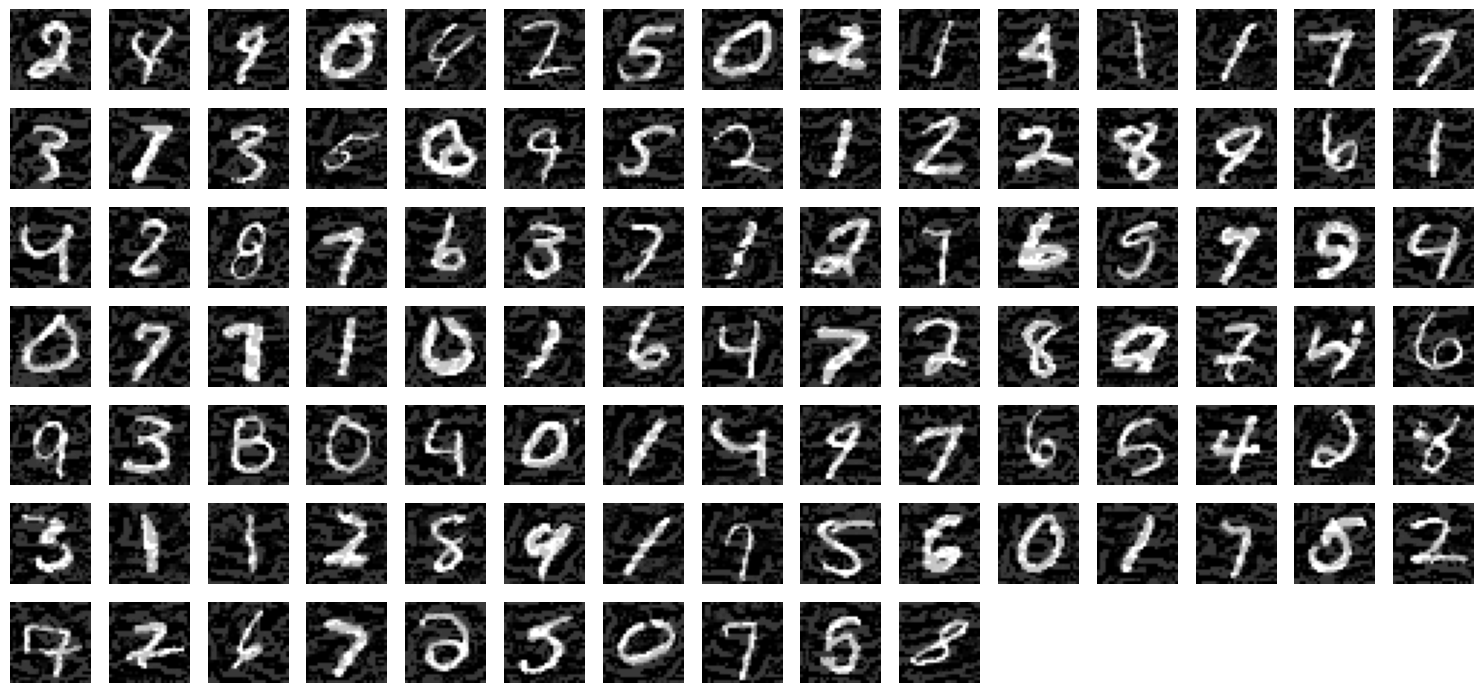

In [69]:
plot_random_images(x_test_bim)

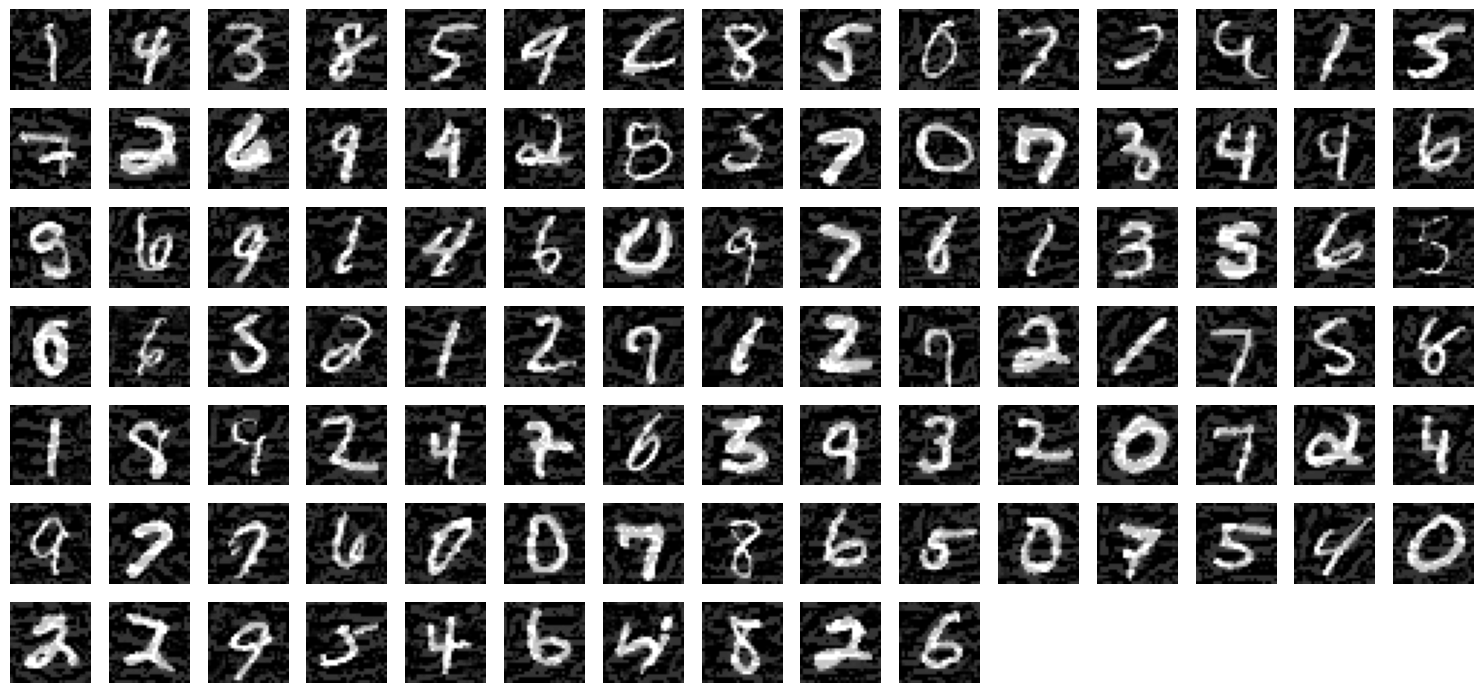

In [70]:
plot_random_images(x_test_pgdlinf)

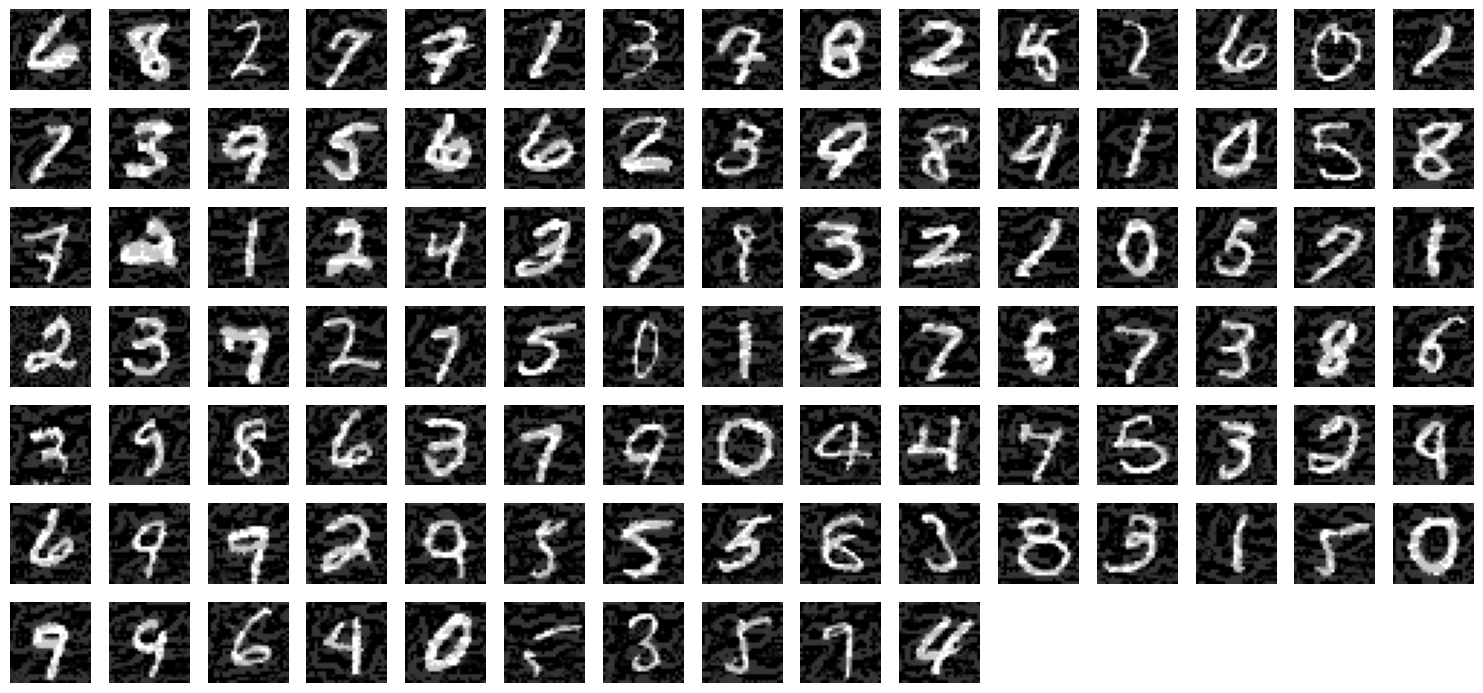

In [71]:
plot_random_images(x_test_apgdlinf)

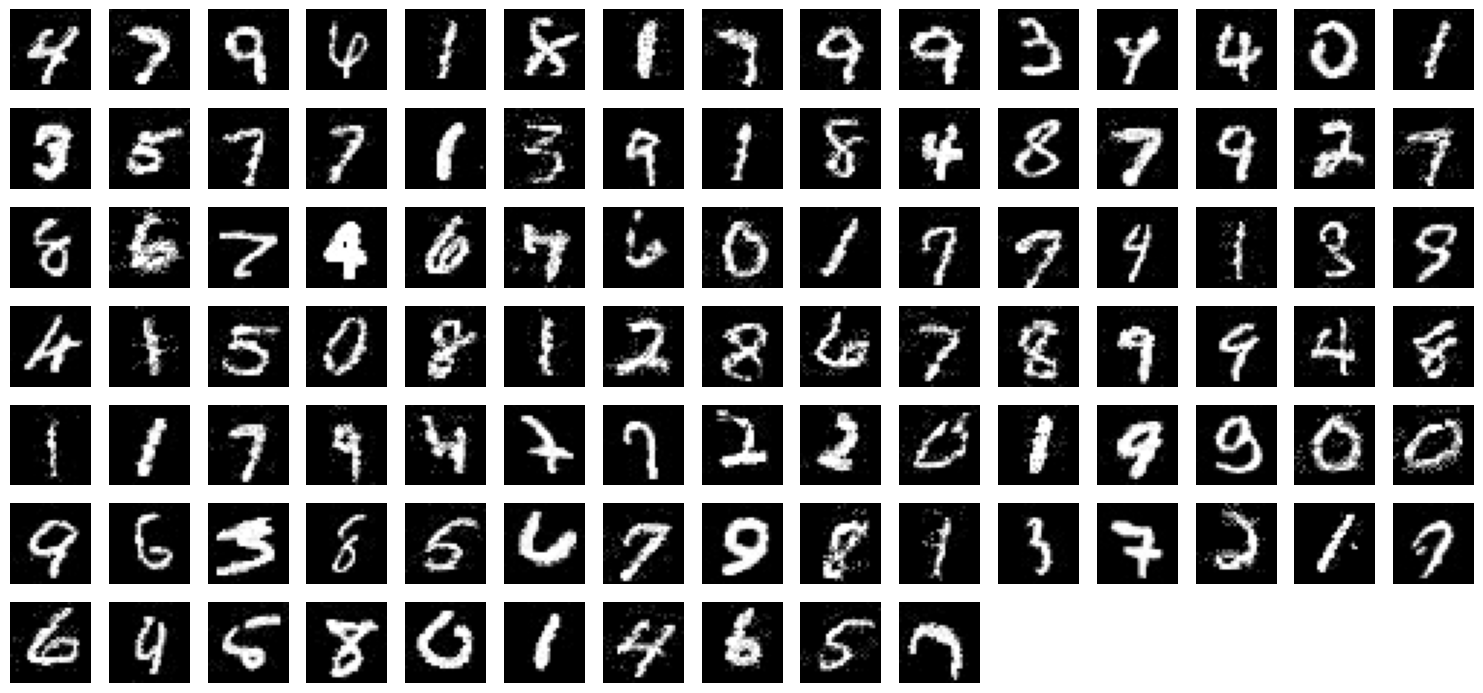

In [72]:
plot_random_images(x_test_cwlinf)

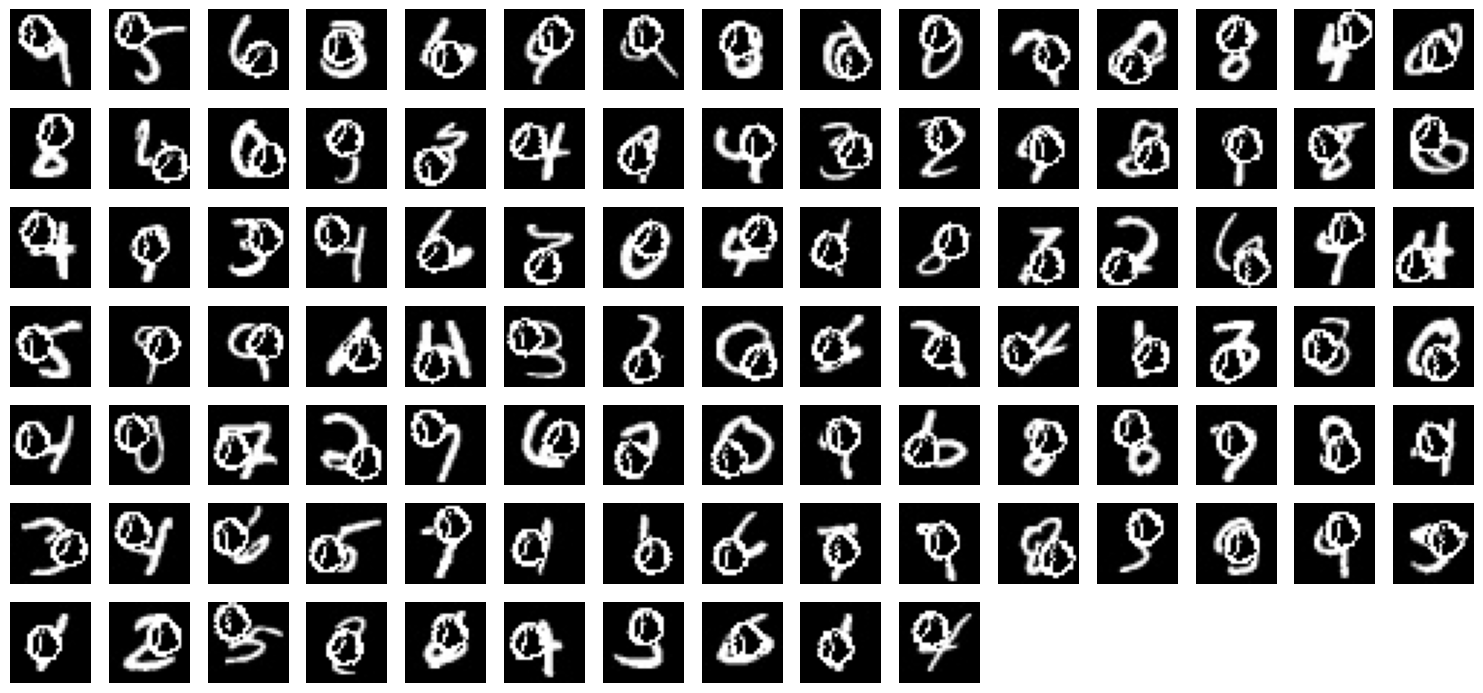

In [73]:
plot_random_images(x_test_ap)

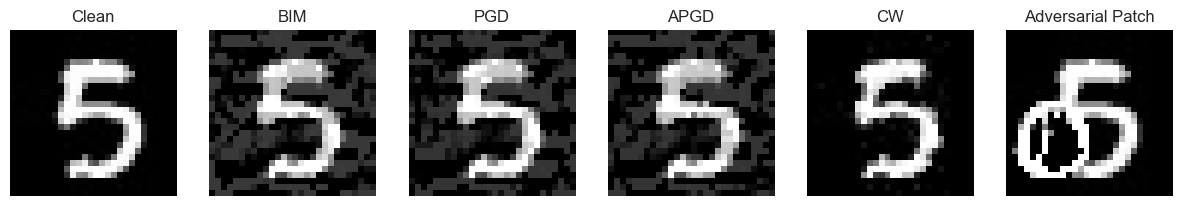

In [51]:
import matplotlib.pyplot as plt

# Select one common index
index = common_indices[5544]  # Change this index as needed

# Plotting parameters
num_images = 6
fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

# Plot each image side by side
images = [x_test[index], x_test_bim[index], x_test_pgdlinf[index], x_test_apgdlinf[index], x_test_cwlinf[index], x_test_ap[index]]
titles = ['Clean', 'BIM', 'PGD', 'APGD', 'CW', 'Adversarial Patch']
for i in range(num_images):
    axes[i].imshow(images[i].reshape(28, 28),cmap='gray')
    axes[i].set_title(titles[i])
    axes[i].axis('off')

plt.show()
